------------------------------------------------------------------------------
Proyecto Integrador Comunicaciones Digitales

"Diseño e implementacion de un trasmisor y receptor LoRa - Primera Parte"

Autor:

- Saqib Daniel Mohammad Cabrejos
- Enzo Leonel Laura Surco
------------------------------------------------------------------------------

Librerias a utilizar:

In [20]:
import numpy as np #Se implementa la libreria numpy de python para el trabajo con arreglos numericos y estadistica
import matplotlib.pyplot as plt #Se implementa la libreria para graficar

La transmision LoRa no transmite los bits uno por uno sino que agrupa los bits en un simbolo y el simbolo se representara como un numero entero "s"
y luego se modulara ese numero como una forma de onda (chirp) a la cual el autor del paper Lorenzo Vangelista hace referencia.

Entonces nuestro Spreading Factor("Factor de propagacion") es entonces nuestra definicion de cantidad de bits por simbolo. Por ende si se desea transmitir un cierto numero de bits, el valor del SF debe ser multiplo del mismo para poder transmitir toda la informacion, segun el SF se agrupara esa cantidad bits a transmitir y a su vez definira que simbolos se pueden transmitir.

Los simbolos quedaran definidos por:  
$ simbolos={0,1,2,...,2^{SF}-1}$

Para el encoder usaremos la ecuacion (1) del paper de Lorenzo Vangelista, la cual es:

$s(nTs)=\sum_{h=0}^{SF-1}w(nTs)_{h}2^{h}$

donde:

. $s(nTs)$: Es el simbolo que representara ese grupo de bits.

. $w(nTs)$: Es el vector de bits del simbolo.

. $nTs$: Seria el tiempo de inicio del simbolo, $n = n° de  simbolo$ y el $Ts$ es el tiempo del simbolo.

El encoder sera pensado de la siguiente forma; si se envian por ejemplo 8 bits con distribucion de probabilidad uniforme, a su vez nuestro SF sera un numero entero 4 entonces la cantidad de simbolos que a la salida del encoder sera de 2 simbolos formados por 4 bits:

Ejemplo:

$bits\, a \,transmitir = {0, 1, 1, 0, 1, 0, 1, 0}$

El encoder implementa esta operacion de forma vectorizada: primero se reorganiza el vector de bits en una matriz donde cada fila contiene SF bits. Luego se crea un vector de potencias de 2 $[2^0, 2^1, ..., 2^{SF-1}]$ y mediante un producto matricial se obtienen todos los simbolos simultaneamente; segun el ejemplo seran: $simbolos = [6, 5]$

$w(nTs)_{1}=0*2^{0}+1*2^{1}+1*2^{2}+0*2^{3}=6 $

$w(nTs)_{2}=1*2^{0}+0*2^{1}+1*2^{2}+0*2^{3}=5 $

In [21]:
#Encoder de bits a simbolos
def encoder(bits, SF):
    bits = np.array(bits).reshape(-1, SF)  # Reshape en grupos de SF bits
    potencias = 2 ** np.arange(SF)  # Vector [1, 2, 4, ..., 2^(SF-1)]
    simbolos = bits @ potencias  # Producto matricial: cada fila por potencias
    return simbolos

El decoder es basicamente la forma que usaremos para descomponer ese simbolo en sus bits correspondientes desde el LSB al MSB donde la cantidad de bits que los conforma sera definido por el SF.

La implementacion vectorizada reorganiza los simbolos en una columna y crea un vector de potencias de 2. Mediante division entera y modulo 2 aplicados con broadcasting, se extraen todos los bits de todos los simbolos simultaneamente. Finalmente se aplana el resultado a un vector 1D.

Ejemplo:

$13 \,\,mod\,\, 2=1=[1]$

$6 \,\,mod \,\,2=0=[1,0]$

$3 \,\,mod \,\,2=1=[1,0,1]$

$1 \,\,mod \,\,2=1=[1,0,1,1]$

In [22]:
#Decoder de simbolos a bits
def decoder(simbolos, SF):
    simbolos = np.array(simbolos).reshape(-1, 1)  # Columna de simbolos
    potencias = 2 ** np.arange(SF)  # Vector [1, 2, 4, ..., 2^(SF-1)]
    bits = (simbolos // potencias) % 2  # Division entera y modulo 2 para extraer cada bit
    return bits.flatten()  # Aplanar a vector 1D

Lo siguiente a realizar sera lo propuesto por el autor del paper Lorenzo Vangelista que basicamente se trata de cada simbolo a la salida del encoder, sera convertido en un "chirp"; este es basicamente una señal la cual crece linealmente con un indice $k=0, 1, 2, ..., 2^{SF}$, empezara desde un valor inicial en frecuencia y hasta un valor final maximo para luego caer. Esta señal chirp esta delimitada en $Bw$.

El autor del paper Lorenzo Vangelista propone una ecuacion para tomar cada simbolo y convertirlo en un chirp; la ecuacion es la siguiente:

$ c(nTs+kT)=\frac{1}{\sqrt{2^{SF}}} e^{j2\pi[(s(nTs)+k)_{mod\,2^{SF}}]k T\frac{B}{2^{SF}}}$

Donde basicamente:

- El termino $(c(nTs+kT))$ hace referencia al chirp de un simbolo, donde el termino $nTs$ es referido al tiempo de simbolo y el indice del mismo a su vez el termino $+kT$ hace referencia a un desplazamiento en un tiempo de muestreo.

La deduccion que se hizo es dividir un poco la ecuacion en pequeñas tramas osea, bloques para reducir los errores de tipeo en el codigo. La funcion "waveform" recibe: el vector de simbolos, el indice k, el ancho de banda Bw, el tiempo de muestreo T y el M (siendo M igual a 2^SF).

La implementacion vectorizada utiliza broadcasting de NumPy: los simbolos se reorganizan en una columna (n_simbolos, 1) y los indices k en una fila (1, M). Al sumar simbolos + k, NumPy expande automaticamente las dimensiones creando una matriz (n_simbolos, M) donde cada fila corresponde a un chirp. Todas las operaciones (modulo, multiplicacion, exponencial compleja) se aplican elemento a elemento sobre toda la matriz, generando todos los chirps simultaneamente sin necesidad de bucles.

In [23]:
#Waveform simbolos a chirps
def waveform(simbolos, k, Bw, T, M):
    simbolos = np.array(simbolos).reshape(-1, 1)  # Columna de simbolos (n_simbolos, 1)
    k = np.array(k).reshape(1, -1)  # Fila de indices k (1, M)
    a = (simbolos + k) % M  # Broadcasting: matriz (n_simbolos, M)
    b = k * T * (Bw / M)  # Vector de frecuencias (1, M)
    chirps = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * a * b)  # Matriz de chirps
    return chirps

Ahora para recuperar los simbolos de los chirps transmitidos el autor del paper Lorenzo Vangelista propone lo siguiente, se calculara el producto punto de la señal transmitida con los chirps conjugados:

$\left<r,c\right>=\sum_{k=0}^{2^{SF}-1}\,r c^{*}$

siendo "r" los chirps transmitidos el conjugado garantizara entonces la ortogonalidad  para que no haya interferencia inter-simbolos. Basicamente el autor propone el optimo demodulador que consiste en proyectar "r" en diferentes señales "c".

La resultante operacion quedara resumida
en dos pasos grandes los cuales son multiplicar "r" cada chirp por un llamado "down-chirp" y despues tomar la transformada discreta de Fourier de el vector resultante.

$\sum_{k=0}^{2^{SF}-1}\,r(nTs+kT) e^{-j2\pi\frac{k^{2}}{2^{SF}}}\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi pk\frac{1}{2^{SF}}}$

La implementacion vectorizada multiplica toda la matriz de señales recibidas por el down-chirp normalizado en una sola operacion. Luego se aplica la FFT con `axis=1` para calcular la transformada de cada fila (cada simbolo) simultaneamente. Finalmente `np.argmax` con `axis=1` encuentra el indice del maximo en cada fila, devolviendo directamente el vector de simbolos detectados.

In [24]:
# N-tuple former; para convertir los chirps en simbolos.
def n_tuple_former(senal_transmitida, k, M):
    down_chirp = np.exp(-1j * 2 * np.pi * (k ** 2) / M)  # Down-chirp base
    down_chirp_norm = down_chirp * (1 / np.sqrt(M))  # Normalizado
    d = senal_transmitida * down_chirp_norm  # Multiplicacion vectorizada (n_simbolos, M)
    fft_result = np.fft.fft(d, axis=1)  # FFT por filas (cada simbolo)
    simbolos_Ntuple = np.argmax(np.abs(fft_result), axis=1)  # Indice del maximo por fila
    return simbolos_Ntuple

Ahora para una mejor simulacion de un entorno real de transmision, añadiremos ruido blanco gaussiano al sistema de media cero y de varianza unitaria; a su vez como nuestra señal chirp tiene forma de exponencial compleja de n° simbolos y de longitud M muestras, pondremos que el ruido parte real y parte imaginaria, a su vez la misma forma del chirp todo con distribucion normal.

$\mathbb{Z\sim}N(0,1)$




Ademas nuestra siguiente idea sera replicar el grafico realizado por el autor del paper Lorenzo Vangelista, el cual hace una comparacion de la SNR en dB contra el BER del sistema, nosotros a su vez haremos tambien una curva para el SER.

La pregunta es ¿Como se realiza? Bueno, primero consideramos que la relacion señal ruido (SNR) es en esencia una relacion de potencias siendo su definicion:

$SNR_{linear}=\frac{Potencia\,de\:la\:senal}{Potencia\:del\:ruido}$

Por ende lo que se hara sera es establecer una potencia de la señal Lora, que segun la investigacion una potencia tipica es de 14 decibelios milivatios (dBm), el autor hace la comparacion en dB pero en nuestro se realizara de forma lineal esto debido a que para operaciones aritmeticas de suma, media y varianza es preferible usar escala lineal.

Entonces definiremos una funcion "ajuste_potencia" la cual lo que hace es hacer que nuestra señal chirp(a cada chirp) tenga la potencia de 14 dBm, y la logica es la siguiente; a la funcion le pasaremos nuestra señal y la potencia del Lora, operaremos para obtener la potencia del chirp

$Potencia\,de\,la\,senal=\frac{1}{N}\sum_{n=0}^{N-1}\left|s\left[n\right]\right|^{2}$


Esta ecuacion hace referencia a la potencia media, lo cual operando se obtendra como potencia media de cada chirp:

$Potencia\,de\,la\,actual=\frac{1}{M}$

Al realizar $np.abs$ en la ecuacion que convierte el simbolo a chirp, como el chirp es una señal compleja nos dara la magnitud eliminando la parte compleja y elevando al cuadrado obtenemos esa potencia actual, ahora lo que necesitamos es que la señal chirp tenga la potencia del Lora, por ende hay que multiplicarlo por un factor escalar.

$Potencia\,de\,la\,nueva\,senal=\frac{1}{N}\sum_{n=0}^{N-1}\left|\alpha s\left[n\right]\right|^{2}$

Operando ese factor escalar se calcula:
$\alpha=\sqrt{\frac{Potencia\,del\,Lora}{Potencia\,Actual}}$

Se aclara que este se realizo se calculo de forma lineal.



In [25]:
#Ajuste de potencia(para la simulacion)
def ajuste_potencia(senal, potencia_delLora):
    potencia_delchirp = np.mean(np.abs(senal)**2)
    factor_escalar = np.sqrt(potencia_delLora / potencia_delchirp)
    return senal * factor_escalar

Para la simulacion con la SNR en escala lineal, obteniendose del valor en dB:

$SNR_{lineal}=10^{\frac{SNR_{dB}}{10}}$

Tomando la anterior definicion de SNR lineal, se podra hacer el calculo de la potencia del ruido:

$Pruido=\frac{Pw}{SNR_{lineal}}$

Por lo tanto lo que se variara es la potencia del ruido. Para agregarle potencia al ruido, tenemos que al ruido multiplicarlo por un factor escalar o tambien variando la varianza; esta deduccion nace que la definicion de la varianza muestreal es:

$Varianza\,muestreal^{2}=\frac{1}{N}\sum_{n=0}^{N-1}\left|xi\left[n\right]-u\right|^{2}$

Recordando obviamente que la media es cero y la varianza de la señal es 1, notamos que la definicion de la varianza muestreal tiene un parecido a la definicion de la potencia media de la señal, y ademas una regla estadistica es:

$Var(\alpha n)=\alpha ^{2}Var(n)$

Como la varianza es unitaria, lo unico que hay que hacer es multiplicar la señal de ruido por un factor, con el cuidado de que sera dos veces el factor la cuadrado uno para la parte real y la otra imaginaria; por ende ese factor sera igual a:

$\alpha = \sqrt{\frac{Pruido}{2}}$


La logica detras del canal selectivo en frecuencia es la siguiente; este canal simula un entorno real de simulacion en la cual ese canal tiene un componente de atenuacion en linea directa y el reflejo de la señal que viene con atenuacion; el porque el sistema son impulsos es porque al convolucion de una señal con sistema SLIT siendo este sistema un impulso es la misma señal.

$h(nT)=\sqrt{0.8}\delta (nT)+\sqrt{0.2}\delta (nT-T)$

Lo que se hara entonces es plantear la definicion de convolucion tal cual, la cual es:

$y[n]=\sum_{k=-\infty }^{\infty }x[k]h[n-k]$

Haciendo un cambio de variable, obtenemos el planteamiento:

$y[n]=\sum_{m=0}^{len(h)-1}h[m]x[n-m]$

Lo que se observa es lo siguiente: h siendo un array que contiene h[0] y h[1] solamente y es de tipo complejo para poder ser multiplicado con la señal compleja.

La implementacion utiliza `np.convolve` con `mode='full'` para calcular la convolucion de cada chirp con el canal h, y luego se trunca al tamaño original del chirp. Esto se aplica a todas las filas de la matriz de chirps mediante una comprension de lista, resultando en:

$y[n]=h[0]x[n]+h[1]x[n-1]$

In [26]:
#Canal selectivo en frecuencia
def canal_selectivo(chirps):
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)], dtype=complex)
    # Convolucion vectorizada: aplicamos np.convolve por filas y truncamos al tamaño original
    salida = np.array([np.convolve(chirp, h, mode='full')[:len(chirp)] for chirp in chirps])
    return salida

Entonces para la simulacion nuestro sistema le pedira al usuario la cantidad de bits a transmitir mas el $SF$, en caso de que los bits no sea multiplo de $SF$ se le pedira de nuevo al usuario que ingrese la cantidad de bits a transmitir.

In [27]:
#############--MAIN--#####################
SF = int(input("Ingresa el Spreading Factor (Simulation by Lorenzo Vangelista SF=7): "))
M = 2 ** SF
while True:
    n_bits = int(input("Ingresa la cantidad de bits a enviar (múltiplo exacto de SF): ")) # Cantidad de bits que voy a enviar; si hago n_bits/SF= obtendre la cantidad de simbolos que salen del encoder
    if n_bits % SF == 0:
        print("El numero de bits es valido")
        break
    else:
        print("El numero de bits no es múltiplo del Spreading Factor. Intenta nuevamente.")

El numero de bits es valido


Defino algunas variables:

In [28]:
Bw = 125e3  #ancho de banda típico de LoRa (125 kHz)
T = 1 / Bw  #Tiempo de muestreo
k = np.arange(M)

# Transmisión original
PotenciaLora_dBm = 14
PotenciaLora_W = 10 ** ((PotenciaLora_dBm - 30) / 10)


Se hara la simulacion para la transmision de una cierta cantidad de bits(los suficientes para obtener una estadistica sufiente) siempre y cuando sea multiplo del SF.

Nuestra primera simulacion se basa en transmitir bits solo con el añadido del ruido gaussiando blanco ajustando la potencia. Para comprobar que nuestro planteamiento es correcto tenemos que comparar con el grafico del autor Lorenzo Vangelista.

SNR =  -12 dB --------->  BER =  0.10425714285714285 |  SER =  0.2062
SNR =  -11 dB --------->  BER =  0.05382857142857143 |  SER =  0.1066
SNR =  -10 dB --------->  BER =  0.01984285714285714 |  SER =  0.0388
SNR =  -11 dB --------->  BER =  0.05382857142857143 |  SER =  0.1066
SNR =  -10 dB --------->  BER =  0.01984285714285714 |  SER =  0.0388
SNR =  -9 dB --------->  BER =  0.0044571428571428574 |  SER =  0.0091
SNR =  -8 dB --------->  BER =  0.0007142857142857143 |  SER =  0.0014
SNR =  -9 dB --------->  BER =  0.0044571428571428574 |  SER =  0.0091
SNR =  -8 dB --------->  BER =  0.0007142857142857143 |  SER =  0.0014
SNR =  -7 dB --------->  BER =  7.142857142857143e-05 |  SER =  0.0001
SNR =  -7 dB --------->  BER =  7.142857142857143e-05 |  SER =  0.0001


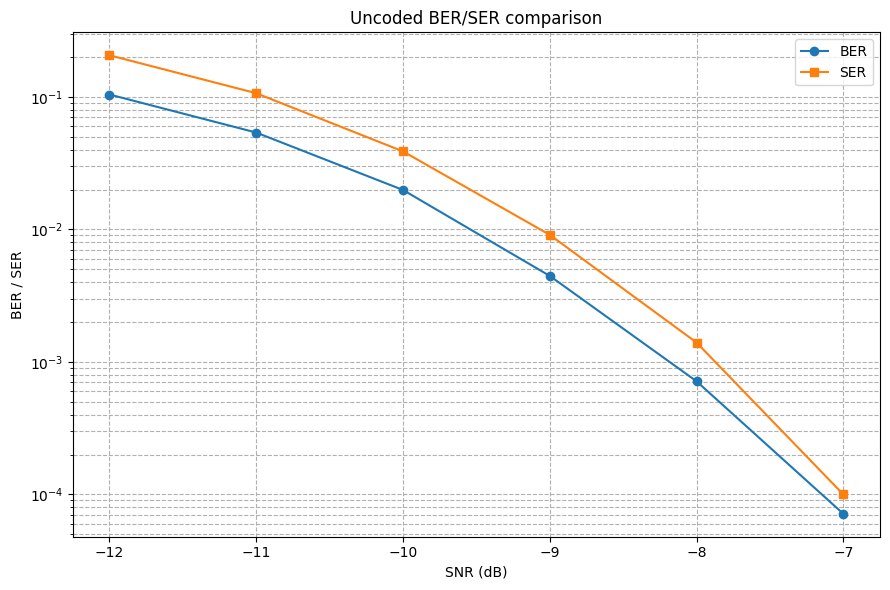

In [29]:

SNR_dBs = np.arange(-12, -6, 1)
BERs = []
SERs = []

# Bucle principal:

for SNR_dB in SNR_dBs:
    SNR_lineal = 10 ** (SNR_dB / 10)
    potencia_ruido = PotenciaLora_W / SNR_lineal

    bits_tx = np.random.randint(0, 2, size=n_bits)
    simbolos_tx = encoder(bits_tx, SF)
    chirps = waveform(simbolos_tx, k, Bw, T, M)

    # Ajustar potencia vectorizado: calculamos potencia por fila y escalamos
    potencia_chirps = np.mean(np.abs(chirps) ** 2, axis=1, keepdims=True)
    factor_escalar = np.sqrt(PotenciaLora_W / potencia_chirps)
    chirps = chirps * factor_escalar

    # Generando ruido independiente para cada símbolo
    ruido_real = np.random.normal(0, 1, chirps.shape)
    ruido_imag = np.random.normal(0, 1, chirps.shape)
    ruido = np.sqrt(potencia_ruido / 2) * (ruido_real + 1j * ruido_imag)

    recibido = chirps + ruido

    simbolos_est = n_tuple_former(recibido, k, M)
    bits_est = decoder(simbolos_est, SF)

    errores_bits = np.sum(bits_tx != bits_est)
    errores_simbolos = np.sum(simbolos_tx != simbolos_est)

    BER = errores_bits / len(bits_tx)
    SER = errores_simbolos / len(simbolos_tx)
    BERs.append(BER)
    SERs.append(SER)

    print("SNR = ", SNR_dB, "dB ---------> ", "BER = ", BER, "| ", "SER = ", SER)

# Se graficaran los resultados en escala logaritmica

plt.figure(figsize=(9, 6))
plt.semilogy(SNR_dBs, BERs, marker='o', label='BER')
plt.semilogy(SNR_dBs, SERs, marker='s', label='SER')
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER/SER comparison')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

Para la segunda simulacion se convolucionara primero la señal a la salida del waveform con el canal SLIT luego añadiendo el ruido blanco gaussiano. Contrastaremos con las del auto del paper Lorenzo Vangelista.

SNR =  -12 dB --------->  BER =  0.16201428571428572 |  SER =  0.3464
SNR =  -11 dB --------->  BER =  0.09657142857142857 |  SER =  0.2197
SNR =  -11 dB --------->  BER =  0.09657142857142857 |  SER =  0.2197
SNR =  -10 dB --------->  BER =  0.051571428571428574 |  SER =  0.1202
SNR =  -10 dB --------->  BER =  0.051571428571428574 |  SER =  0.1202
SNR =  -9 dB --------->  BER =  0.0227 |  SER =  0.0609
SNR =  -9 dB --------->  BER =  0.0227 |  SER =  0.0609
SNR =  -8 dB --------->  BER =  0.009142857142857144 |  SER =  0.0281
SNR =  -8 dB --------->  BER =  0.009142857142857144 |  SER =  0.0281
SNR =  -7 dB --------->  BER =  0.003742857142857143 |  SER =  0.0133
SNR =  -7 dB --------->  BER =  0.003742857142857143 |  SER =  0.0133
SNR =  -6 dB --------->  BER =  0.002057142857142857 |  SER =  0.0072
SNR =  -6 dB --------->  BER =  0.002057142857142857 |  SER =  0.0072
SNR =  -5 dB --------->  BER =  0.0005571428571428572 |  SER =  0.0021
SNR =  -5 dB --------->  BER =  0.00055714285

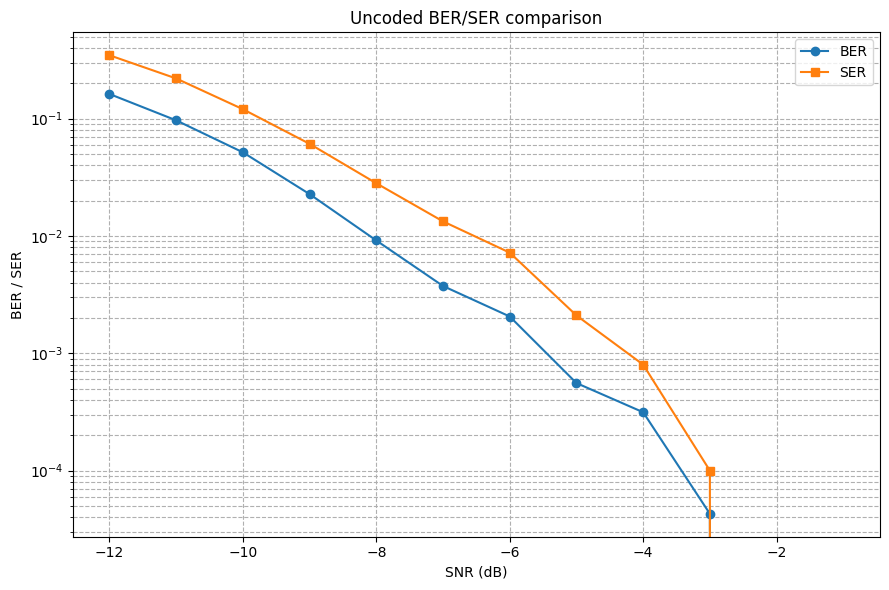

In [30]:
SNR_dBs = np.arange(-12, 0, 1)
BERs = []
SERs = []

#Segundo bloque

for SNR_dB in SNR_dBs:
    SNR_lineal = 10 ** (SNR_dB / 10)
    potencia_ruido = PotenciaLora_W / SNR_lineal

    bits_tx = np.random.randint(0, 2, size=n_bits)
    simbolos_tx = encoder(bits_tx, SF)
    chirps = waveform(simbolos_tx, k, Bw, T, M)

    # Ajustar potencia vectorizado: calculamos potencia por fila y escalamos
    potencia_chirps = np.mean(np.abs(chirps) ** 2, axis=1, keepdims=True)
    factor_escalar = np.sqrt(PotenciaLora_W / potencia_chirps)
    chirps = chirps * factor_escalar

    tx_senal = canal_selectivo(chirps)

    # Generando ruido independiente para cada símbolo
    ruido_real = np.random.normal(0, 1, chirps.shape)
    ruido_imag = np.random.normal(0, 1, chirps.shape)
    ruido = np.sqrt(potencia_ruido / 2) * (ruido_real + 1j * ruido_imag)

    recibido = tx_senal + ruido

    simbolos_est = n_tuple_former(recibido, k, M)
    bits_est = decoder(simbolos_est, SF)

    errores_bits = np.sum(bits_tx != bits_est)
    errores_simbolos = np.sum(simbolos_tx != simbolos_est)

    BER = errores_bits / len(bits_tx)
    SER = errores_simbolos / len(simbolos_tx)
    BERs.append(BER)
    SERs.append(SER)

    print("SNR = ", SNR_dB, "dB ---------> ", "BER = ", BER, "| ", "SER = ", SER)

# Se graficaran los resultados en escala logaritmica

plt.figure(figsize=(9, 6))
plt.semilogy(SNR_dBs, BERs, marker='o', label='BER')
plt.semilogy(SNR_dBs, SERs, marker='s', label='SER')
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER/SER comparison')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()